In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score

In [2]:
X_train = pd.read_csv('../../datasets/Toy/X_train.csv',index_col=0)  
X_test = pd.read_csv('../../datasets/Toy/X_test.csv',index_col=0)  
y_train = pd.read_csv('../../datasets/Toy/y_train.csv',index_col=0)  
y_test = pd.read_csv('../../datasets/Toy/y_test.csv',index_col=0)  

split_ratio = 0.2

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=split_ratio, random_state=42)


In [3]:
X_train

,x0,x1,x2,x3,x4,x5
97651,0.554358,2.348586,0.052736,0.505530,165.739262,1
45938,-0.435011,1.000571,0.893536,0.800912,158.539590,0
66358,2.746904,6.026028,-0.283311,1.418933,163.893527,1
62628,3.671753,9.611451,1.066627,3.190901,154.704743,1
89874,3.282473,6.839671,0.571231,1.972984,160.736258,1
...,...,...,...,...,...,...
145783,0.317447,3.398681,-1.194427,2.243835,164.407875,1
58423,1.532524,4.306448,-1.401718,2.353885,163.188793,0
53791,0.215282,1.996896,-0.135332,0.649558,168.378115,1
156820,0.290969,3.086943,0.682983,1.076200,165.634839,1


In [4]:
X_train.columns

Index(['x0', 'x1', 'x2', 'x3', 'x4', 'x5'], dtype='object')

In [5]:
y_test

,y
73032,1617.993424
193271,1780.596763
66713,1679.185088
92710,1842.917089
12849,1614.700338
...,...
90175,1620.016923
186257,1619.385255
98550,1658.525709
28035,1621.077476


In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [7]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, hidden_layers, hidden_units, dropout, dropout_array, input_dim, output_dim, activation=nn.ReLU(),norm=False):
        if hidden_layers != len(hidden_units):
            print("Error: wrong size of hidden_layers or hidden_units")
            return
        layers = []
        i = 0
        if norm:
            layers.append(nn.BatchNorm1d(input_dim))

        super(Net, self).__init__()
        
        layers.append(nn.Linear(input_dim, hidden_units[i]))
        layers.append(activation)
        if dropout:
            layers.append(nn.Dropout(dropout_array[i]))

        for _ in range(hidden_layers - 1):
            i += 1
            layers.append(nn.Linear(hidden_units[i-1], hidden_units[i]))
            layers.append(activation)
            if dropout:
                layers.append(nn.Dropout(dropout_array[i]))

        layers.append(nn.Linear(hidden_units[-1], output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)


In [26]:
config={'batch_size': 25, 'lr': 0.0004990515469382572, 'num_epochs': 100, 'hidden_layers': 3, 'hidden_units': [128, 64, 32], 'dropout': False, 'dropout_array': [0.38283509966903684, 0.14655095633529086, 0.5393755103727268], 'activation': nn.ReLU(), 'norm': False,'patience': 20}

input_dim = X_train_scaled.shape[1]
output_dim = 1

In [27]:
train_ds = TensorDataset(torch.Tensor(X_train_scaled), torch.Tensor(y_train.to_numpy()))
val_ds = TensorDataset(torch.Tensor(X_val_scaled), torch.Tensor(y_val.to_numpy()))
test_ds = TensorDataset(torch.Tensor(X_test_scaled), torch.Tensor(y_test.to_numpy()))

In [28]:
train_loader = DataLoader(train_ds, batch_size=config["batch_size"], shuffle=True)
test_loader = DataLoader(test_ds, batch_size=config["batch_size"])

In [29]:
net = Net(hidden_layers=config["hidden_layers"], hidden_units=config["hidden_units"], dropout=config["dropout"], dropout_array=config["dropout_array"], input_dim=input_dim, output_dim=output_dim, activation=config["activation"], norm=config["norm"])

In [30]:
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
net = net.to(device)

In [31]:
summary(net,input_size=(6,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]             896
              ReLU-2                  [-1, 128]               0
            Linear-3                   [-1, 64]           8,256
              ReLU-4                   [-1, 64]               0
            Linear-5                   [-1, 32]           2,080
              ReLU-6                   [-1, 32]               0
            Linear-7                    [-1, 1]              33
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.04
Estimated Total Size (MB): 0.05
----------------------------------------------------------------


In [32]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

In [33]:
criterion = RMSELoss()
optimizer = optim.Adam(net.parameters(), lr=config["lr"])

In [34]:
def train_net(net, train_loader, criterion, optimizer, device):
    net.train()
    train_loss = 0
    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device).view(-1, 1)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    return train_loss / len(train_loader), net


def test_net(net, test_loader, criterion, device):
    net.eval()
    test_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device).view(-1, 1)

            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()

    return test_loss / len(test_loader)


def train(config):
    train_loader = DataLoader(train_ds, batch_size=config["batch_size"], shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=config["batch_size"])
    net = Net(hidden_layers=config["hidden_layers"], hidden_units=config["hidden_units"], dropout=config["dropout"], dropout_array=config["dropout_array"], input_dim=input_dim, output_dim=output_dim, activation=config["activation"], norm=config["norm"])
    criterion = RMSELoss()
    optimizer = optim.Adam(net.parameters(), lr=config["lr"])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)

    train_losses = []
    val_losses = []

    best_val_loss = float("inf")
    patience = config['patience']
    early_stop = False

    for epoch in range(config["num_epochs"]):
        train_loss,net = train_net(net, train_loader, criterion, optimizer, device)
        val_loss = test_net(net, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch [{epoch+1}/{config['num_epochs']}], Train Loss: {train_loss:.4f}, Test Loss: {val_loss:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience = config['patience']
        else:
            patience -= 1
            if patience == 0:
                print("Early stopping...")
                early_stop = True
                break

    if not early_stop:
        print("Training complete.")

    return train_losses, val_losses, net


In [35]:
train_losses, val_losses, mod = train(config)

Epoch [1/100], Train Loss: 113.0472, Test Loss: 3.8525
Epoch [2/100], Train Loss: 3.5148, Test Loss: 3.1014
Epoch [3/100], Train Loss: 2.8709, Test Loss: 2.5926
Epoch [4/100], Train Loss: 2.6380, Test Loss: 2.2855
Epoch [5/100], Train Loss: 2.5205, Test Loss: 2.1584
Epoch [6/100], Train Loss: 2.4455, Test Loss: 2.6529
Epoch [7/100], Train Loss: 2.3393, Test Loss: 1.8296
Epoch [8/100], Train Loss: 2.3050, Test Loss: 1.8758
Epoch [9/100], Train Loss: 2.3036, Test Loss: 2.4508
Epoch [10/100], Train Loss: 2.2347, Test Loss: 2.2753
Epoch [11/100], Train Loss: 2.2079, Test Loss: 1.9466
Epoch [12/100], Train Loss: 2.2235, Test Loss: 2.0089
Epoch [13/100], Train Loss: 2.2098, Test Loss: 2.1350
Epoch [14/100], Train Loss: 2.1862, Test Loss: 2.9979
Epoch [15/100], Train Loss: 2.1516, Test Loss: 1.9643
Epoch [16/100], Train Loss: 2.1684, Test Loss: 2.1582
Epoch [17/100], Train Loss: 2.1997, Test Loss: 1.9544
Epoch [18/100], Train Loss: 2.1316, Test Loss: 2.1800
Epoch [19/100], Train Loss: 2.1504,

In [36]:
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

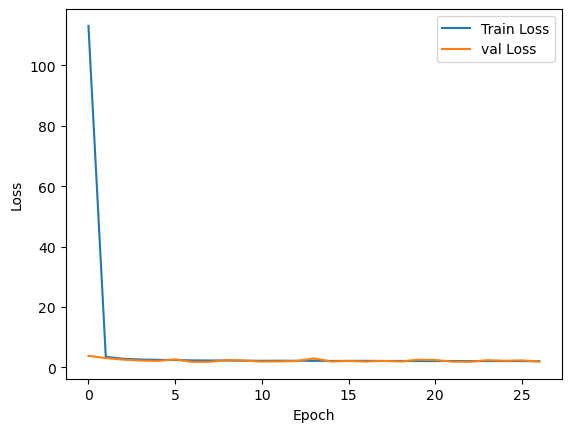

In [37]:
plot_losses(train_losses, val_losses)

In [38]:
def plot_predictions(net, data_loader, device):
    net.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device).view(-1, 1)
            outputs = net(inputs)
            y_true.extend(targets.cpu().numpy())
            y_pred.extend(outputs.cpu().numpy())

    plt.scatter(y_true, y_pred)
    plt.xlabel("True Values")
    plt.ylabel("Predictions")
    plt.show()

def r_squared(y_true, y_pred):
    y_bar = np.mean(y_true)
    ss_tot = np.sum((y_true - y_bar) ** 2)
    ss_res = np.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2


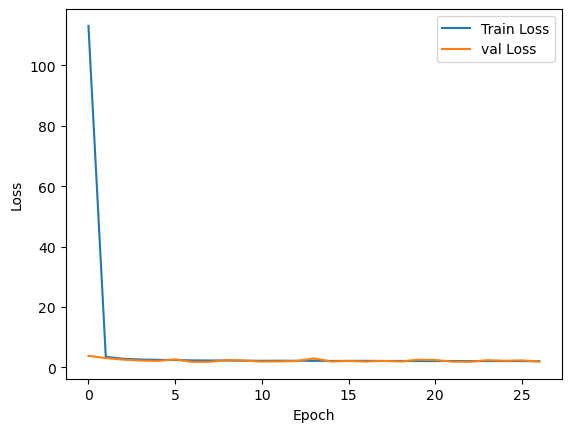

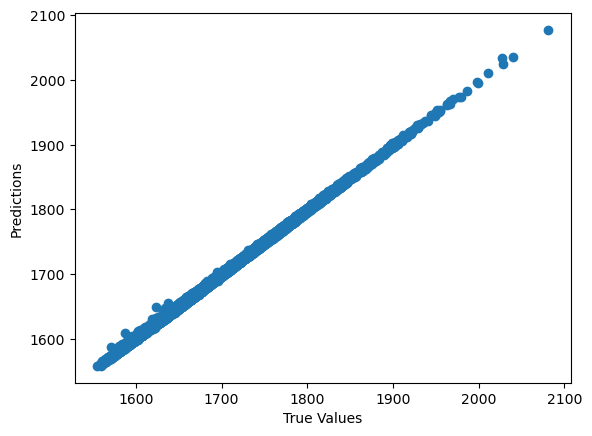

R^2 score: 0.9985213805343695
Train_loss: 2.0276570320129395
Validation_loss: 1.9620720148086548
Test_loss: 1.9830399751663208


In [39]:
#train_losses, test_losses = train(config)
plot_losses(train_losses, val_losses)
plot_predictions(mod, test_loader, device)
y_true = y_test
y_pred = mod(torch.Tensor(X_test_scaled).to(device)).cpu().detach().numpy()
r2 = r2_score(y_true, y_pred)
print("R^2 score:", r2)
y_train_tensor = torch.Tensor(y_train.values).to(device)
y_val_tensor = torch.Tensor(y_val.values).to(device)
y_test_tensor = torch.Tensor(y_test.values).to(device)
print("Train_loss:",criterion(mod(torch.Tensor(X_train_scaled).to(device)),y_train_tensor).item())
print("Validation_loss:",criterion(mod(torch.Tensor(X_val_scaled).to(device)),y_val_tensor).item())
print("Test_loss:",criterion(mod(torch.Tensor(X_test_scaled).to(device)),y_test_tensor).item())


In [41]:
torch.save(mod, '../../Models/toy_model_9985')